In [1]:
%pip install aequitas # library for metrics
# restart when prompted, no futher issues

In [2]:
%pip install optuna # configuration search space optimizer

In [3]:
import copy
import os
import lightgbm as lgbm  # Tested ML method
import numpy as np       # Random number generation
import seaborn as sns    # Plotting library
import pandas as pd      # Read/write data
import yaml              # Read hyperparameter space configuration
import xgboost           # Tested ML method
from aequitas.group import Group                # Fairness metrics
from matplotlib import pyplot as plt            # Plotting method
from sklearn.preprocessing import LabelEncoder  # Categorical encoding for LGBM models
from sklearn import metrics                     # ROC metrics
from sklearn.ensemble import RandomForestClassifier
import joblib

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
!cp /content/drive/MyDrive/Colab\ Notebooks/ECE697/Project/random_search.py .

In [6]:
from random_search import RandomValueTrial, suggest_callable_hyperparams  # Random search wrapper methods

In [7]:
# Read hyperparameter space for the LGBM Models, expected structure is presented bellow

with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/lightgbm_hyperparameter_space_original.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [8]:
# The expected structure is the following:
hyperparam_space

{'LightGBM': {'classpath': 'lightgbm.LGBMClassifier',
  'kwargs': {'n_estimators': {'type': 'int',
    'range': [20, 10000],
    'log': True},
   'max_depth': {'type': 'int', 'range': [3, 30]},
   'learning_rate': {'type': 'float', 'range': [0.02, 0.1], 'log': True},
   'num_leaves': {'type': 'int', 'range': [10, 100], 'log': True},
   'boosting_type': ['gbdt', 'goss'],
   'min_data_in_leaf': {'type': 'int', 'range': [5, 200], 'log': True},
   'max_bin': {'type': 'int', 'range': [100, 500]},
   'enable_bundle': [True, False]}}}

In [9]:
# Testing a random search suggestion:
trial = RandomValueTrial(seed=1)
suggest_callable_hyperparams(trial, hyperparam_space)

{'classpath': 'lightgbm.LGBMClassifier',
 'n_estimators': 263,
 'max_depth': 23,
 'learning_rate': 0.020003681922217444,
 'num_leaves': 19,
 'boosting_type': 'gbdt',
 'min_data_in_leaf': 9,
 'max_bin': 238,
 'enable_bundle': False}

In [10]:
# Define path to datasets. Replace `base_path` with the appropriate value.
base_path = "/content/drive/MyDrive/Colab Notebooks/ECE697/Project/"
model_save_dir = "/content/drive/MyDrive/Colab Notebooks/ECE697/Project/Models/"

# Change experiments to original variants
# Feedzai already generated dataset variants based on age for us
datasets_paths = {
    "Base":    base_path + "Base.csv",
    "TypeI":   base_path + "VariantI.csv",
    "TypeII":  base_path + "VariantII.csv",
    "TypeIII": base_path + "VariantIII.csv",
    "TypeIV":  base_path + "VariantIV.csv",
    "TypeV":   base_path + "VariantV.csv",
 }

In [11]:
# Read the datasets with pandas.
datasets = {key: pd.read_csv(path) for key, path in datasets_paths.items()}

In [12]:
# Define the label field and categorical columns.
label = "fraud_bool"

categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]

In [13]:
# Create the train and test sets. Shuffle data with `sample` method.
# The split was done by month. The first 6 months as the train, the last 2 months as test.
train_dfs = {key: df[df["month"]<6].sample(frac=1, replace=False) for key, df in datasets.items()}
test_dfs = {key: df[df["month"]>=6].sample(frac=1, replace=False) for key, df in datasets.items()}

In [14]:
# Encode the categorical variables in the datasets to integers.
# This is expected by LGBM (or columns with the `categorical` data type).

for name in datasets.keys():  # For each dataset in the suite
    train = train_dfs[name]
    test = test_dfs[name]

    for feat in categorical_features:
        encoder = LabelEncoder()
        encoder.fit(train[feat])  # Fit an encoder to the train set.
        train[feat] = encoder.transform(train[feat])  # Transform train set.
        test[feat] = encoder.transform(test[feat])    # Transform test set.

In [15]:
def pad_int(model_id, zfill=3):
    return str(model_id).zfill(zfill)

##LightGBM##

In [16]:
# Cell with train loop. Takes 9 hours. Must refresh after

# Define number of trials in Random search.
n_trials=1
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

# Variable to store the results.
runs = {}

for trial in range(n_trials):
    ctr = trial
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparameters.

    # Update list of tested hyperparameters.
    prev_hyperparams = runs.get("hyperparams", [])
    prev_hyperparams.append(test_hyperparams)
    runs["hyperparams"] = prev_hyperparams

    for dataset_name in datasets.keys():  # Run hyperparameters on all variants of datastes.
        # Instantiate LGBM model
        model = lgbm.LGBMClassifier(n_jobs=10, **test_hyperparams)  # change n_jobs -> either 1 or 2 for better performance
        X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_train = train_dfs[dataset_name]["fraud_bool"]
        X_test = test_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_test = test_dfs[dataset_name]["fraud_bool"]

        # Fit model to training data.
        model.fit(X_train, y_train, categorical_feature=categorical_features)
        # Obtain predictions in test data.
        predictions = model.predict_proba(X_test)[:, 1]

        # Obtain ROC curve for the predictions.
        fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
        # Obtain threshold and recall. We select 5% FPR as threshold.
        threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
        recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

        # Binarize predictions for Aequitas.
        preds_binary = (predictions > threshold).astype(int)

        # Create a dataframe with protected group column, predictions and labels.
        # Here, we select age >= 50 as threshold.
        aequitas_df = pd.DataFrame(
            {
               "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
                "score": preds_binary,
                "label_value": y_test.values

            }
        )

        #print(aequitas_df)
        # Obtain FPR results for different groups.
        g = Group()
        aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

        # Store the results for the trained model
        results = {}
        results["recall"] = recall
        results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
        results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
        results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
        results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

        # save every model, with identifier in file name
        # dataset_name is Type X
        # rewrite save_dir with actual model saving location
        v_num = pad_int(ctr)
        joblib.dump(model, os.path.join(model_save_dir, "LGBM", f"{dataset_name}_{v_num}_lgbm.pkl"))

        # Store the results in the runs variable
        prev_runs = runs.get(dataset_name, [])
        prev_runs.append(results)
        runs[dataset_name] = prev_runs

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 8151, number of negative: 786838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2791

In [ ]:
# Create a dataframe with the results for each model in each dataset.
rs_results = pd.DataFrame(runs)

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, variant, metric):
    col = results[variant]
    values = []
    for idx, val in col.items():
        values.append(val[metric])
    return values

In [ ]:
# Obtain the relevant metrics to plots from the dataframe.
variants = list(datasets_paths.keys())

plot_results = {"Variant": [], "Recall": [], "FPR Ratio": []}

for variant in variants:
    plot_results["Recall"] += get_results(rs_results, variant, "recall")
    # Obtain the FPR if both groups.
    for fpr_younger, fpr_older in zip(get_results(rs_results, variant, "fpr Younger"), get_results(rs_results, variant, "fpr Older")):
        # Calculate FPR ratio as lower fpr / higher fpr
        if fpr_younger > fpr_older:
            plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
        else:
            plot_results["FPR Ratio"] += [fpr_younger/fpr_older]
    plot_results["Variant"] += [variant] * len(get_results(rs_results, variant, "recall"))

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

# Save dataframe for empirical comparison with augmented datasets
plot_results.to_csv(os.path.join(model_save_dir, "LGBM", "plot_results.csv"))

In [ ]:
top_n = 5

base_top_5_idx = plot_results.loc[plot_results['Variant'] == 'Base'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_1_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeI'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_2_top_5idx = plot_results.loc[plot_results['Variant'] == 'TypeII'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_3_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeIII'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_4_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeIV'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_5_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeV'].sort_values('Recall', ascending=False).head(top_n).index.values

top_5_lgbm_per_variant = {
    "Base": base_top_5_idx.tolist(),
    "TypeI": variant_1_top_5_idx.tolist(),
    "TypeII": variant_2_top_5idx.tolist(),
    "TypeIII": variant_3_top_5_idx.tolist(),
    "TypeIV": variant_4_top_5_idx.tolist(),
    "TypeV": variant_5_top_5_idx.tolist()
}

with open(os.path.join(model_save_dir, "LGBM", "best_models_idx.txt"), "w") as f:
    print(top_5_lgbm_per_variant, file=f)

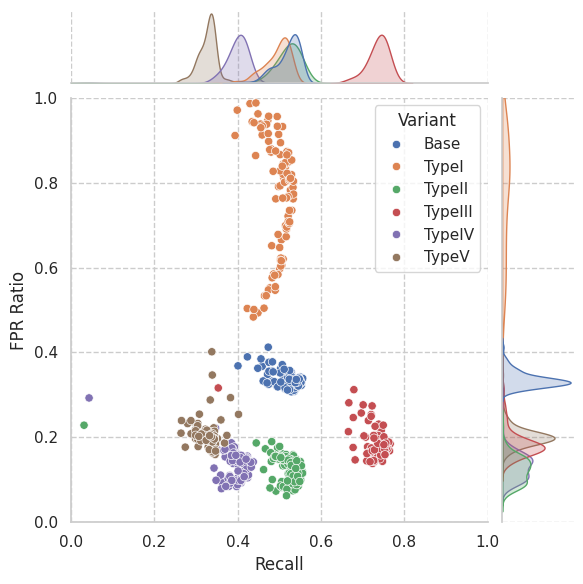

In [ ]:
# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", hue="Variant")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Create the final plot. Highlight the top models:
# top_n = 5
top_models_base = plot_results.loc[plot_results['Variant'] == 'Base'].sort_values('Recall', ascending=False).head(top_n).index.values
top_models = copy.deepcopy(top_models_base)
for i in range(1, 6):
    top_models = np.r_[top_models, top_models_base + (100 * i)]

plot_results['index'] = plot_results.index
plot_results['is_top'] = plot_results.apply(lambda x: 1 if x['index'] in top_models else 0, axis=1)

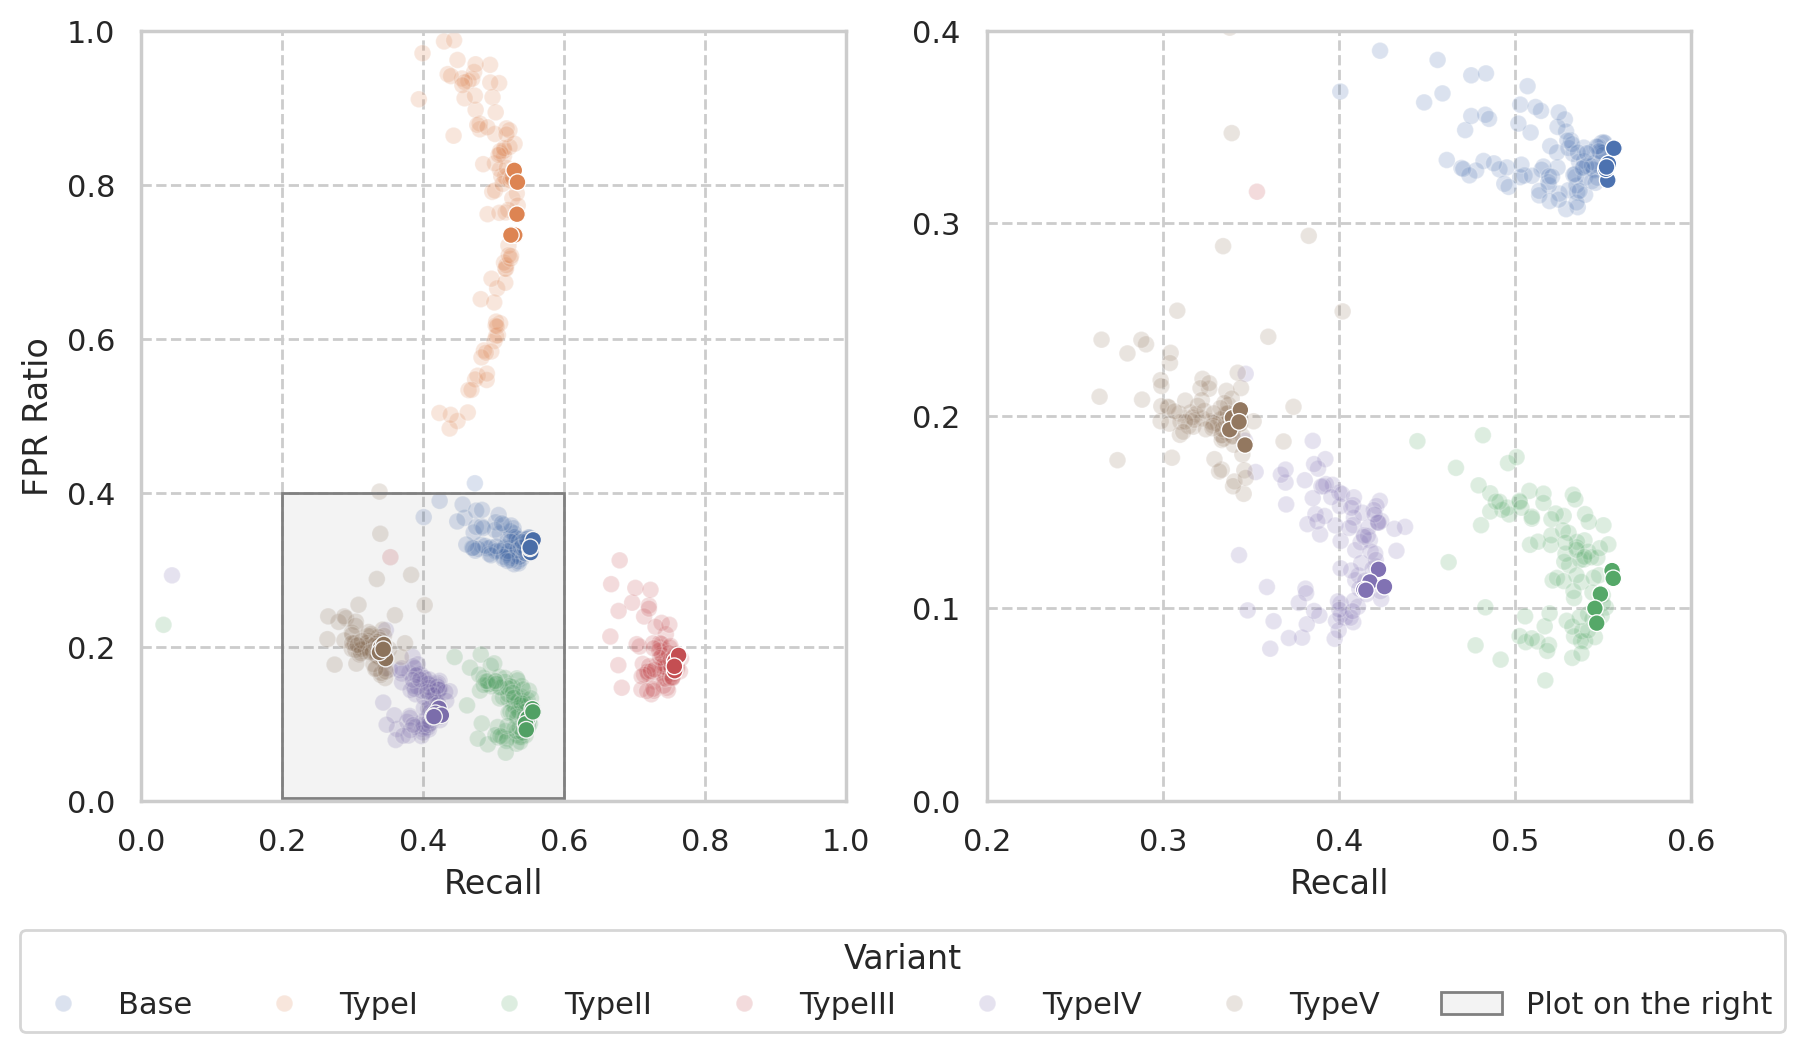

In [ ]:
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha":0.1})
DPI = 200
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.figsize'] = (10,5)

fig, (ax1, ax2) = plt.subplots(1, 2)

# LEFT PLOT
sns.scatterplot(ax=ax1, data=plot_results.loc[(~plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2)
sns.scatterplot(ax=ax1, data=plot_results.loc[plot_results.index.isin(top_models), :], x="Recall", y="FPR Ratio", hue="Variant", legend=False)
ax1.set(
    ylim=(0,1),
    xlim=(0,1)
)

# RIGHT PLOT
sns.scatterplot(ax=ax2, data=plot_results.loc[(~plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2, palette=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
sns.scatterplot(ax=ax2, data=plot_results.loc[(plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", palette=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
# Determines graph size in right plot
ax2.set(
    ylim=(0.0,0.4),
    ylabel="",
    xticks=np.arange(0.2, 0.7, 0.1),
    yticks=np.arange(0, 0.5, 0.1),
    xlim=(0.2, 0.6),
)

rect = plt.Rectangle((0.2, 0.004), 0.4, 0.396, facecolor=(0.1, 0.1, 0.1, 0.05), edgecolor="grey", linestyle="-") # determines rectangle in left plot
ax1.add_patch(rect)
handles, labels = ax1.get_legend_handles_labels()
handles = list(handles) + [rect]
labels = list(labels) + ["Plot on the right"]
ax1.legend(handles, labels, title="Variant")

sns.move_legend(
    ax1,
    loc="lower center",
    bbox_to_anchor=[1.08, -0.32],
    ncol=7
)

##XGBoost##

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/xgboost_hyperspace_parameter.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
# Cell with train loop. Takes >3 hours

# Define number of trials in Random search.
n_trials=100
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

# Variable to store the results.
runs = {}

for trial in range(n_trials):
    ctr = trial
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters.

    # Update list of tested hyperparameters.
    prev_hyperparams = runs.get("hyperparams", [])
    prev_hyperparams.append(test_hyperparams)
    runs["hyperparams"] = prev_hyperparams

    for dataset_name in datasets.keys():  # Run hyperparameters on all variants of datastes.
        model = xgboost.XGBClassifier(n_jobs=10, **test_hyperparams, enable_categorical=True)  # enable_categorical=True, # may need to add this
        X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_train = train_dfs[dataset_name]["fraud_bool"]
        X_test = test_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_test = test_dfs[dataset_name]["fraud_bool"]

        # Fit model to training data.
        model.fit(X_train, y_train)#, categorical_feature=categorical_features)
        # Obtain predictions in test data.
        predictions = model.predict_proba(X_test)[:, 1]

        # Obtain ROC curve for the predictions.
        fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
        # Obtain threshold and recall. We select 5% FPR as threshold.
        threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
        recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

        # Binarize predictions for Aequitas.
        preds_binary = (predictions > threshold).astype(int)

        # Create a dataframe with protected group column, predictions and labels.
        # Here, we select age >= 50 as threshold.
        aequitas_df = pd.DataFrame(
            {
               "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
                "score": preds_binary,
                "label_value": y_test.values

            }
        )

        #print(aequitas_df)
        # Obtain FPR results for different groups.
        g = Group()
        aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

        # Store the results for the trained model
        results = {}
        results["recall"] = recall
        results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
        results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
        results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
        results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

        # save every model, with identifier in file name
        # dataset_name is Type X
        # rewrite save_dir with actual model saving location
        v_num = pad_int(ctr)
        joblib.dump(model, os.path.join(model_save_dir, "XGB", f"{dataset_name}_{v_num}_xgb.pkl"))

        # Store the results in the runs variable
        prev_runs = runs.get(dataset_name, [])
        prev_runs.append(results)
        runs[dataset_name] = prev_runs

In [ ]:
# Create a dataframe with the results for each model in each dataset.
rs_results = pd.DataFrame(runs)

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, variant, metric):
    col = results[variant]
    values = []
    for idx, val in col.items():
        values.append(val[metric])
    return values

In [ ]:
# Obtain the relevant metrics to plots from the dataframe.
variants = list(datasets_paths.keys())

plot_results = {"Variant": [], "Recall": [], "FPR Ratio": []}

for variant in variants:
    plot_results["Recall"] += get_results(rs_results, variant, "recall")
    # Obtain the FPR if both groups.
    for fpr_younger, fpr_older in zip(get_results(rs_results, variant, "fpr Younger"), get_results(rs_results, variant, "fpr Older")):
        # Calculate FPR ratio as lower fpr / higher fpr
        if fpr_younger > fpr_older:
            plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
        else:
            plot_results["FPR Ratio"] += [fpr_younger/fpr_older]
    plot_results["Variant"] += [variant] * len(get_results(rs_results, variant, "recall"))

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

# Save dataframe for empirical comparison with augmented datasets
plot_results.to_csv(os.path.join(model_save_dir, "XGB", "plot_results.csv"))

In [ ]:
top_n = 5

base_top_5_idx = plot_results.loc[plot_results['Variant'] == 'Base'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_1_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeI'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_2_top_5idx = plot_results.loc[plot_results['Variant'] == 'TypeII'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_3_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeIII'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_4_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeIV'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_5_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeV'].sort_values('Recall', ascending=False).head(top_n).index.values

top_5_xgb_per_variant = {
    "Base": base_top_5_idx.tolist(),
    "TypeI": variant_1_top_5_idx.tolist(),
    "TypeII": variant_2_top_5idx.tolist(),
    "TypeIII": variant_3_top_5_idx.tolist(),
    "TypeIV": variant_4_top_5_idx.tolist(),
    "TypeV": variant_5_top_5_idx.tolist()
}

with open(os.path.join(model_save_dir, "XGB", "best_models_idx.txt"), "w") as f:
    print(top_5_xgb_per_variant, file=f)

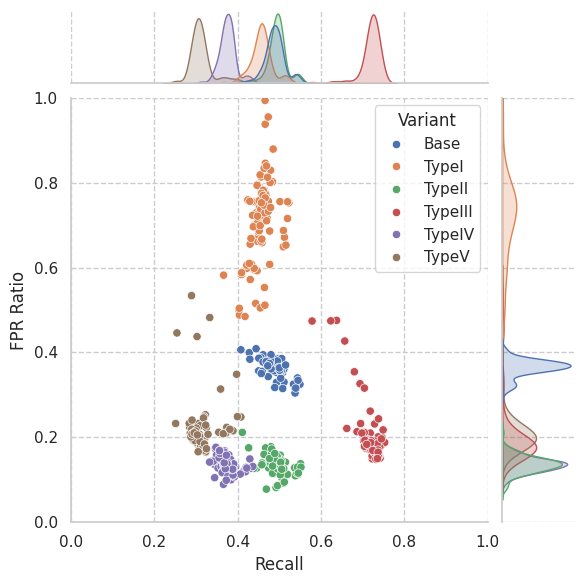

In [ ]:
# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", hue="Variant")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Create the final plot. Highlight the top models:
# top_n = 5
top_models_base = plot_results.loc[plot_results['Variant'] == 'Base'].sort_values('Recall', ascending=False).head(top_n).index.values
top_models = copy.deepcopy(top_models_base)
for i in range(1, 6):
    top_models = np.r_[top_models, top_models_base + (100 * i)]

plot_results['index'] = plot_results.index
plot_results['is_top'] = plot_results.apply(lambda x: 1 if x['index'] in top_models else 0, axis=1)

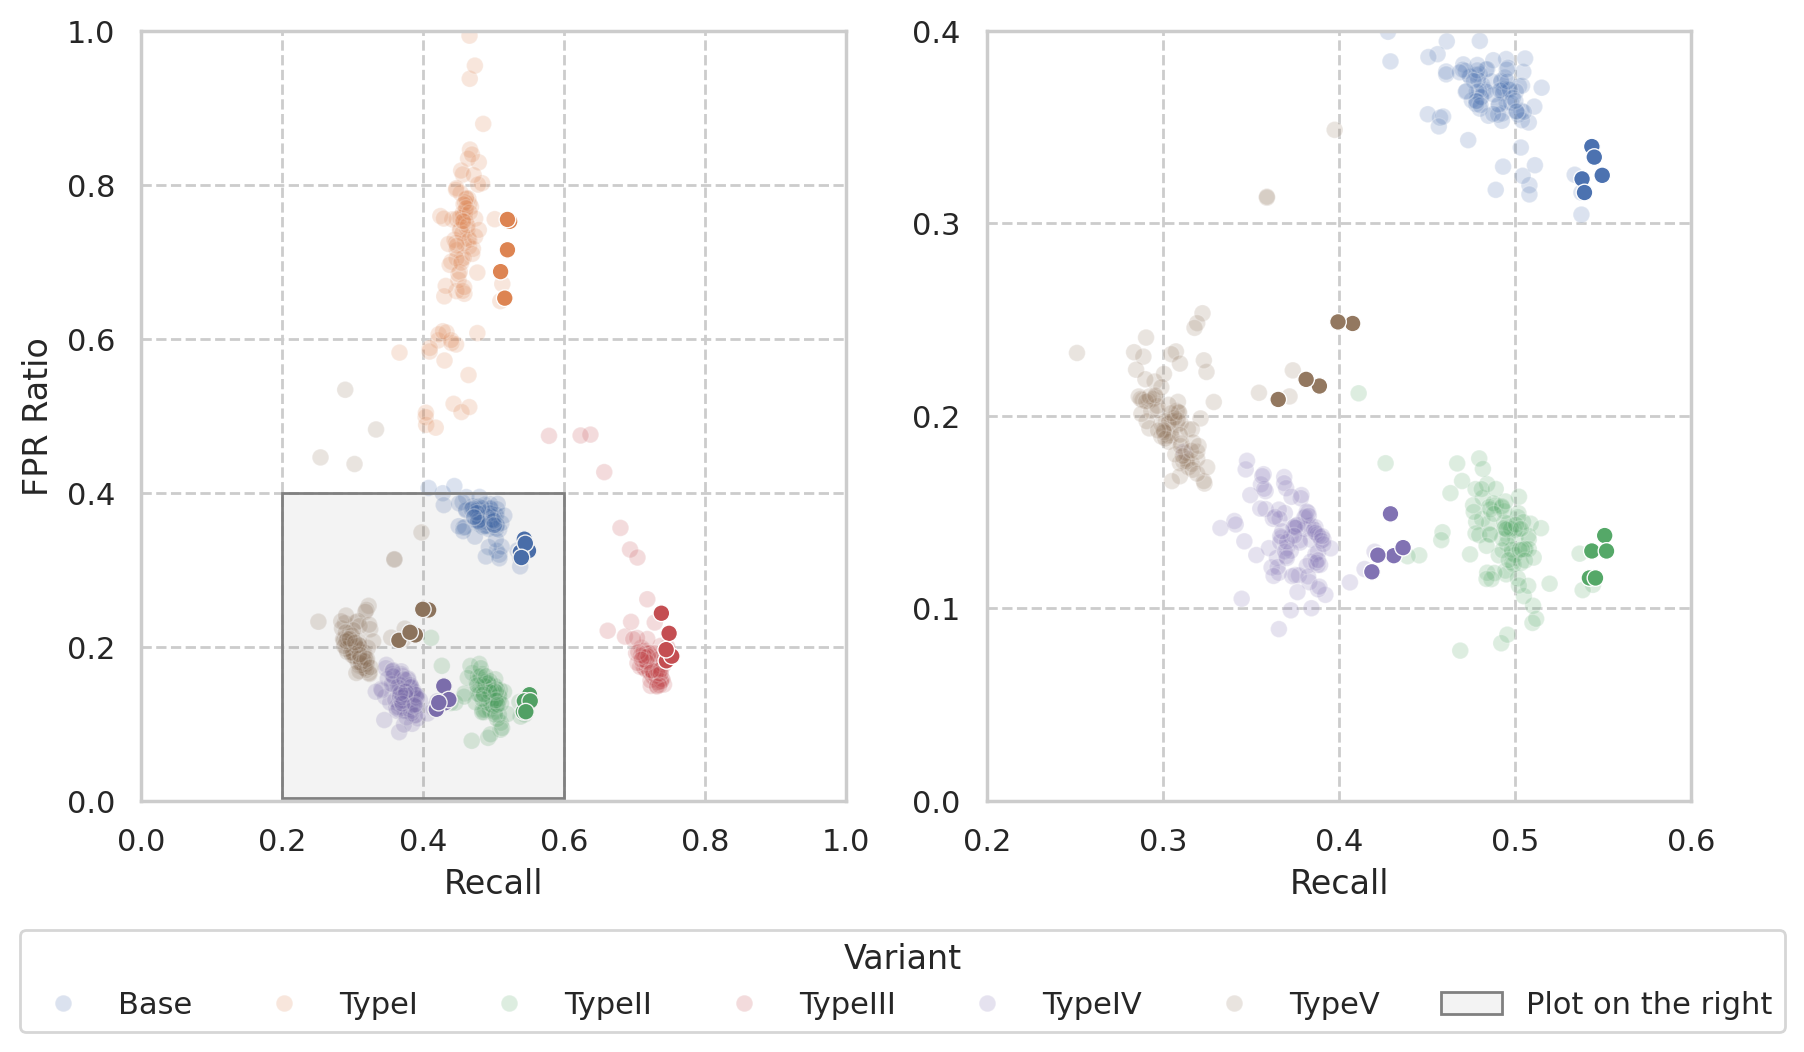

In [ ]:
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha":0.1})
DPI = 200
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.figsize'] = (10,5)

fig, (ax1, ax2) = plt.subplots(1, 2)

# LEFT PLOT
sns.scatterplot(ax=ax1, data=plot_results.loc[(~plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2)
sns.scatterplot(ax=ax1, data=plot_results.loc[plot_results.index.isin(top_models), :], x="Recall", y="FPR Ratio", hue="Variant", legend=False)
ax1.set(
    ylim=(0,1),
    xlim=(0,1)
)

# RIGHT PLOT
sns.scatterplot(ax=ax2, data=plot_results.loc[(~plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2, palette=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
sns.scatterplot(ax=ax2, data=plot_results.loc[(plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", palette=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
# Determines graph size in right plot
ax2.set(
    ylim=(0,0.4),
    ylabel="",
    xticks=np.arange(0.2, 0.8, 0.1),
    yticks=np.arange(0, 0.5, 0.1),
    xlim=(0.2, 0.6),
)

rect = plt.Rectangle((0.2, 0.004), 0.4, 0.396, facecolor=(0.1, 0.1, 0.1, 0.05), edgecolor="grey", linestyle="-")
ax1.add_patch(rect)
handles, labels = ax1.get_legend_handles_labels()
handles = list(handles) + [rect]
labels = list(labels) + ["Plot on the right"]
ax1.legend(handles, labels, title="Variant")

sns.move_legend(
    ax1,
    loc="lower center",
    bbox_to_anchor=[1.08, -0.32],
    ncol=7
)

##Random Forest##

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/randomforest_hyperspace_parameter.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
# Cell with train loop. Supposedly takes < 2 hours -> ~6 hours

# Define number of trials in Random search.
n_trials=100
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

# Variable to store the results.
runs = {}

for trial in range(n_trials):
    ctr = trial
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters.

    # Update list of tested hyperparameters.
    prev_hyperparams = runs.get("hyperparams", [])
    prev_hyperparams.append(test_hyperparams)
    runs["hyperparams"] = prev_hyperparams

    for dataset_name in datasets.keys():  # Run hyperparameters on all variants of datastes.
        model = RandomForestClassifier(n_jobs=10, **test_hyperparams) # enable_categorical=True, # may need to add this
        X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_train = train_dfs[dataset_name]["fraud_bool"]
        X_test = test_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_test = test_dfs[dataset_name]["fraud_bool"]

        # Fit model to training data.
        model.fit(X_train, y_train)
        # Obtain predictions in test data.
        predictions = model.predict_proba(X_test)[:, 1]

        # Obtain ROC curve for the predictions.
        fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
        # Obtain threshold and recall. We select 5% FPR as threshold.
        threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
        recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

        # Binarize predictions for Aequitas.
        preds_binary = (predictions > threshold).astype(int)

        # Create a dataframe with protected group column, predictions and labels.
        # Here, we select age >= 50 as threshold.
        aequitas_df = pd.DataFrame(
            {
               "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
                "score": preds_binary,
                "label_value": y_test.values

            }
        )

        #print(aequitas_df)
        # Obtain FPR results for different groups.
        g = Group()
        aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

        # Store the results for the trained model
        results = {}
        results["recall"] = recall
        results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
        results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
        results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
        results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

        # save every model, with identifier in file name
        # dataset_name is Type X
        # rewrite save_dir with actual model saving location
        v_num = pad_int(ctr)
        joblib.dump(model, os.path.join(model_save_dir, "RF", f"{dataset_name}_{v_num}_rf.pkl"))

        # Store the results in the runs variable
        prev_runs = runs.get(dataset_name, [])
        prev_runs.append(results)
        runs[dataset_name] = prev_runs

In [ ]:
# Create a dataframe with the results for each model in each dataset.
rs_results = pd.DataFrame(runs)

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, variant, metric):
    col = results[variant]
    values = []
    for idx, val in col.items():
        values.append(val[metric])
    return values

In [ ]:
# Obtain the relevant metrics to plots from the dataframe.
variants = list(datasets_paths.keys())

plot_results = {"Variant": [], "Recall": [], "FPR Ratio": []}

for variant in variants:
    plot_results["Recall"] += get_results(rs_results, variant, "recall")
    # Obtain the FPR if both groups.
    for fpr_younger, fpr_older in zip(get_results(rs_results, variant, "fpr Younger"), get_results(rs_results, variant, "fpr Older")):
        # Calculate FPR ratio as lower fpr / higher fpr
        if fpr_younger > fpr_older:
            plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
        else:
            plot_results["FPR Ratio"] += [fpr_younger/fpr_older]
    plot_results["Variant"] += [variant] * len(get_results(rs_results, variant, "recall"))

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

# Save dataframe for empirical comparison with augmented datasets
plot_results.to_csv(os.path.join(model_save_dir, "RF", "plot_results.csv"))

In [ ]:
top_n = 5

base_top_5_idx = plot_results.loc[plot_results['Variant'] == 'Base'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_1_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeI'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_2_top_5idx = plot_results.loc[plot_results['Variant'] == 'TypeII'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_3_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeIII'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_4_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeIV'].sort_values('Recall', ascending=False).head(top_n).index.values
variant_5_top_5_idx = plot_results.loc[plot_results['Variant'] == 'TypeV'].sort_values('Recall', ascending=False).head(top_n).index.values

top_5_rf_per_variant = {
    "Base": base_top_5_idx.tolist(),
    "TypeI": variant_1_top_5_idx.tolist(),
    "TypeII": variant_2_top_5idx.tolist(),
    "TypeIII": variant_3_top_5_idx.tolist(),
    "TypeIV": variant_4_top_5_idx.tolist(),
    "TypeV": variant_5_top_5_idx.tolist()
}

with open(os.path.join(model_save_dir, "RF", "best_models_idx.txt"), "w") as f:
    print(top_5_rf_per_variant, file=f)

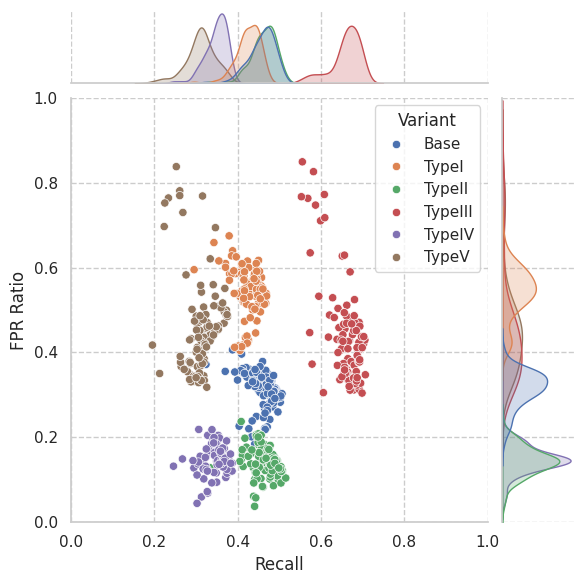

In [ ]:
# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", hue="Variant")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Create the final plot. Highlight the top models:
# top_n = 5
top_models_base = plot_results.loc[plot_results['Variant'] == 'Base'].sort_values('Recall', ascending=False).head(top_n).index.values
top_models = copy.deepcopy(top_models_base)
for i in range(1, 6):
    top_models = np.r_[top_models, top_models_base + (100 * i)]

plot_results['index'] = plot_results.index
plot_results['is_top'] = plot_results.apply(lambda x: 1 if x['index'] in top_models else 0, axis=1)

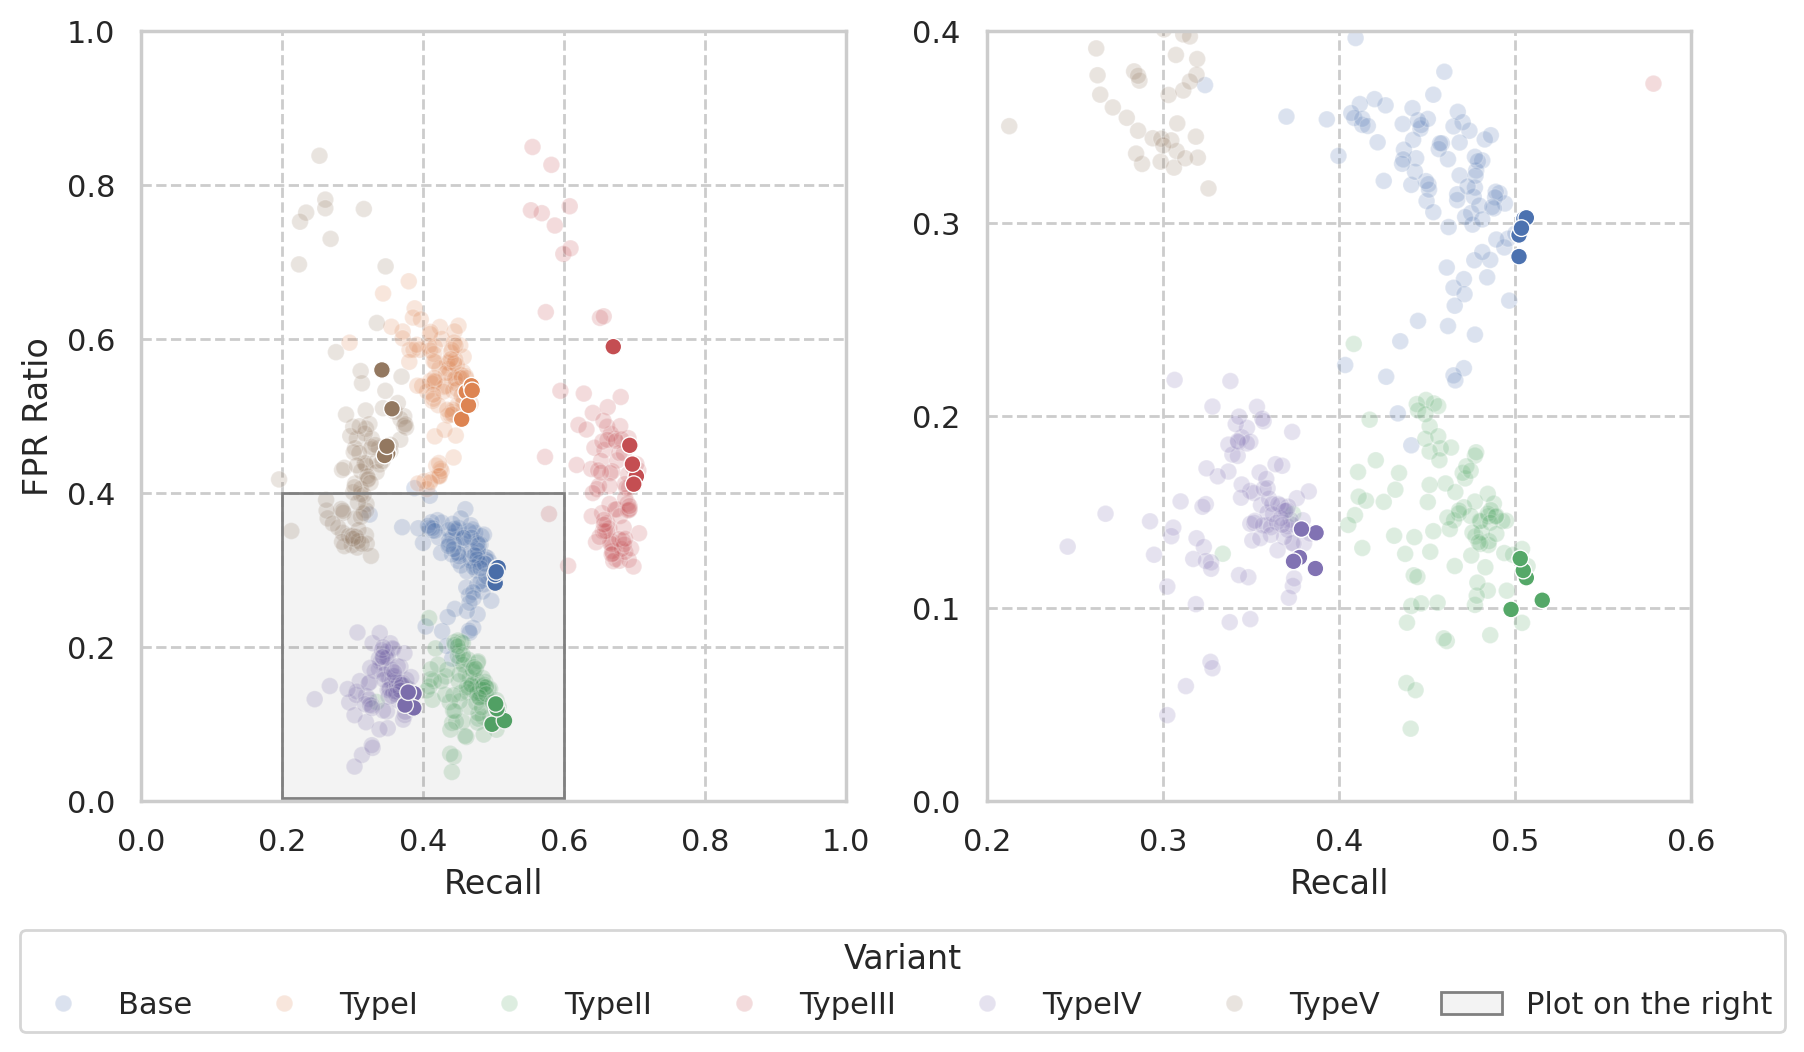

In [ ]:
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha":0.1})
DPI = 200
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.figsize'] = (10,5)

fig, (ax1, ax2) = plt.subplots(1, 2)

# LEFT PLOT
sns.scatterplot(ax=ax1, data=plot_results.loc[(~plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2)
sns.scatterplot(ax=ax1, data=plot_results.loc[plot_results.index.isin(top_models), :], x="Recall", y="FPR Ratio", hue="Variant", legend=False)
ax1.set(
    ylim=(0,1),
    xlim=(0,1)
)

# RIGHT PLOT
sns.scatterplot(ax=ax2, data=plot_results.loc[(~plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2, palette=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
sns.scatterplot(ax=ax2, data=plot_results.loc[(plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", palette=[sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
# Determines graph size in right plot
ax2.set(
    ylim=(0,0.4),
    ylabel="",
    xticks=np.arange(0.2, 0.7, 0.1),
    yticks=np.arange(0, 0.5, 0.1),
    xlim=(0.2, 0.6),
)

rect = plt.Rectangle((0.2, 0.004), 0.4, 0.396, facecolor=(0.1, 0.1, 0.1, 0.05), edgecolor="grey", linestyle="-")
ax1.add_patch(rect)
handles, labels = ax1.get_legend_handles_labels()
handles = list(handles) + [rect]
labels = list(labels) + ["Plot on the right"]
ax1.legend(handles, labels, title="Variant")

sns.move_legend(
    ax1,
    loc="lower center",
    bbox_to_anchor=[1.08, -0.32],
    ncol=7
)

In [ ]:
plot_results

,Variant,Recall,FPR Ratio,index,is_top
0,TypeI,0.421821,0.300641,0,0
1,TypeI,0.404448,0.328069,1,0
2,TypeI,0.439194,0.385624,2,0
3,TypeI,0.444753,0.326030,3,0
4,TypeI,0.431550,0.374875,4,0
...,...,...,...,...,...
595,TypeVI,0.407227,0.497180,595,0
596,TypeVI,0.447186,0.522048,596,0
597,TypeVI,0.396108,0.534631,597,0
598,TypeVI,0.439541,0.519195,598,0
